## Clustering electric power usage of individual household electric power consumption Data Set using K-Means

The dataset for individual household electric power consumption is available at:

https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

### Importing libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from urllib.request import urlretrieve
from zipfile import ZipFile
from sklearn import preprocessing
from sklearn.cluster import KMeans
import tensorflow as tf

print(tf.__version__)
print(tf.keras.__version__)

2.0.0-dev20190518
2.2.4-tf


### Downloading data

We could use the browser to download household_power_consumption.zip and decompress the file and extract the household_power_consumption.txt file, but it is preferable to write few line of codes to automate this process.

In [2]:
from urllib.request import urlretrieve

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"

urlretrieve(url, "household_power_consumption.zip")

('household_power_consumption.zip',
 <http.client.HTTPMessage at 0x7f44b0658ba8>)

### Extracting the .zip file

Following lines of code extract the file in specific location.

In [3]:
from zipfile import ZipFile 
  
file_name = "household_power_consumption.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    zip.printdir()
    
    print("Extracting all the files now...") 
    zip.extractall("./dataset/") 
    print("Done!")

File Name                                             Modified             Size
household_power_consumption.txt                2012-10-12 13:38:54    132960755
Extracting all the files now...
Done!


### Importing the data using pandas library

As we want to cluster power usage, we are going to only use Global_active_power coulmn. We also detect the number of missing values in that coulmn.

In [3]:
def load_data():
    data_path = os.path.join("./dataset/household_power_consumption.txt")
    return pd.read_csv(data_path, sep=';', header=0, usecols = ["Date","Time","Global_active_power"], 
                       low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, 
                       index_col=['datetime'], na_values=["NaN","?"])

raw_dataset = load_data()

raw_dataset.head()

,Global_active_power
datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [4]:
raw_dataset.isna().sum()

Global_active_power    25979
dtype: int64

### Filling missing value with mean

In [5]:
raw_dataset.iloc[:,-1] = raw_dataset.iloc[:,-1].fillna(raw_dataset.iloc[:,-1].mean())

raw_dataset.isna().sum()

Global_active_power    0
dtype: int64

### Framing and resampling the dataset to be grouped by whole hour

In [6]:
hourly_data = raw_dataset.resample("H").sum()

hourly_data["Time"] = hourly_data.index.hour

hourly_data.index = hourly_data.index.date

hourly_data.index.name = "Date"

print(hourly_data.dtypes)

print(hourly_data.shape)

print(hourly_data.head())

Global_active_power    float64
Time                     int64
dtype: object
(34589, 2)
            Global_active_power  Time
Date                                 
2006-12-16              152.024    17
2006-12-16              217.932    18
2006-12-16              204.014    19
2006-12-16              196.114    20
2006-12-16              183.388    21


In [7]:
hourly_data.to_csv("./dataset/hourly_household_power_consumption.csv")

#hourly_dataset = pd.read_csv("./dataset/hourly_household_power_consumption.csv")

hourly_dataset = pd.read_csv("./dataset/hourly_household_power_consumption.csv", index_col = ["Date"])

print(hourly_dataset.dtypes)

print(hourly_dataset.shape)

print(hourly_dataset.head())

#hourly_dataset.index.is_unique

Global_active_power    float64
Time                     int64
dtype: object
(34589, 2)
            Global_active_power  Time
Date                                 
2006-12-16              152.024    17
2006-12-16              217.932    18
2006-12-16              204.014    19
2006-12-16              196.114    20
2006-12-16              183.388    21


### Reshaping the DataFrame by given index / column values.

In [8]:
hourly_dataset_pivoted = hourly_dataset.pivot(columns = "Time")

hourly_dataset_pivoted.T.head()

Date                      2006-12-16  2006-12-17  2006-12-18  2006-12-19  \
                    Time                                                   
Global_active_power 0            NaN     112.948      16.582      50.228   
                    1            NaN     200.964      18.798      21.182   
                    2            NaN      95.236      17.068      19.634   
                    3            NaN      99.732      18.596      18.498   
                    4            NaN     132.946      61.580      19.670   

Date                      2006-12-20  2006-12-21  2006-12-22  2006-12-23  \
                    Time                                                   
Global_active_power 0         27.590      92.152      16.016     101.894   
                    1         15.520      83.878      16.320     103.368   
                    2         47.062      76.494      16.058     102.046   
                    3         18.602      18.156      16.432     106.292   
                    4         17.340      14.804      15.856     113.496   

Date                      2006-12-24  2006-12-25  ...  2010-11-17  2010-11-18  \
                    Time                          ...                           
Global_active_power 0        241.680      59.974  ...      22.062      26.512   
                    1        196.542      72.406  ...      17.644      23.438   
                    2        138.182      26.280  ...      19.708      30.812   
                    3         96.406      35.398  ...      19.532      61.152   
                    4         94.566      34.720  ...      35.310      27.576   

Date                      2010-11-19  2010-11-20  2010-11-21  2010-11-22  \
                    Time                                                   
Global_active_power 0         20.514      19.018      31.194      22.050   
                    1         16.624      17.094      17.628      16.792   
                    2         57.292      21.402      53.808      17.002   
                    3         18.882      18.616      19.794      16.496   
                    4         20.324      19.592      20.674      22.098   

Date                      2010-11-23  2010-11-24  2010-11-25  2010-11-26  
                    Time                                                  
Global_active_power 0         21.910      21.502      18.208      17.658  
                    1         17.546      15.918      17.380      16.860  
                    2         16.942      30.126      15.982      16.406  
                    3         16.470      45.074      20.144      17.902  
                    4         21.610      19.218      22.624      18.842  

[5 rows x 1442 columns]

In [9]:
hourly_dataset_pivoted = hourly_dataset_pivoted.dropna()

hourly_dataset_pivoted.T.head()

Date                      2006-12-17  2006-12-18  2006-12-19  2006-12-20  \
                    Time                                                   
Global_active_power 0        112.948      16.582      50.228      27.590   
                    1        200.964      18.798      21.182      15.520   
                    2         95.236      17.068      19.634      47.062   
                    3         99.732      18.596      18.498      18.602   
                    4        132.946      61.580      19.670      17.340   

Date                      2006-12-21  2006-12-22  2006-12-23  2006-12-24  \
                    Time                                                   
Global_active_power 0         92.152      16.016     101.894     241.680   
                    1         83.878      16.320     103.368     196.542   
                    2         76.494      16.058     102.046     138.182   
                    3         18.156      16.432     106.292      96.406   
                    4         14.804      15.856     113.496      94.566   

Date                      2006-12-25  2006-12-26  ...  2010-11-16  2010-11-17  \
                    Time                          ...                           
Global_active_power 0         59.974     145.456  ...      19.428      22.062   
                    1         72.406     144.158  ...      17.536      17.644   
                    2         26.280     144.656  ...      61.610      19.708   
                    3         35.398     146.944  ...      18.044      19.532   
                    4         34.720     179.550  ...      16.748      35.310   

Date                      2010-11-18  2010-11-19  2010-11-20  2010-11-21  \
                    Time                                                   
Global_active_power 0         26.512      20.514      19.018      31.194   
                    1         23.438      16.624      17.094      17.628   
                    2         30.812      57.292      21.402      53.808   
                    3         61.152      18.882      18.616      19.794   
                    4         27.576      20.324      19.592      20.674   

Date                      2010-11-22  2010-11-23  2010-11-24  2010-11-25  
                    Time                                                  
Global_active_power 0         22.050      21.910      21.502      18.208  
                    1         16.792      17.546      15.918      17.380  
                    2         17.002      16.942      30.126      15.982  
                    3         16.496      16.470      45.074      20.144  
                    4         22.098      21.610      19.218      22.624  

[5 rows x 1440 columns]

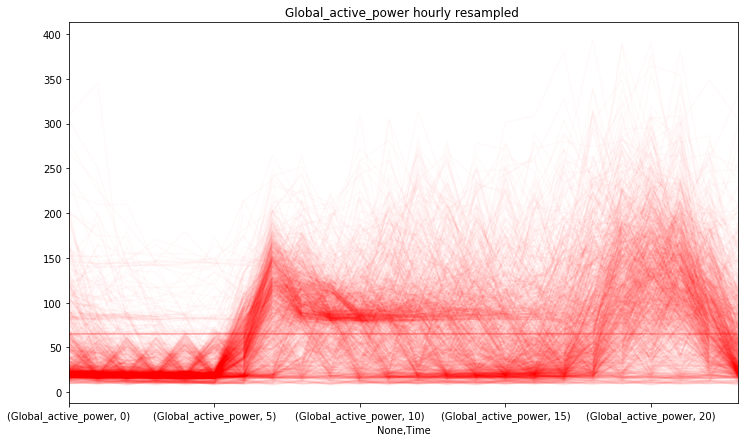

In [13]:
hourly_dataset_pivoted.T.plot(figsize = (12,7), title = "Global_active_power hourly resampled ", 
                              legend = False, color = 'red', alpha = 0.02)

### Normalize the data

In [14]:
hourly_dataset_pivoted_stats = hourly_dataset_pivoted.describe()

hourly_dataset_pivoted_stats = hourly_dataset_pivoted_stats.transpose()

@tf.function
def norm(X):
  return (X - hourly_dataset_pivoted_stats['mean']) / hourly_dataset_pivoted_stats['std']

x = hourly_dataset_pivoted.values.copy()

x_scaled = norm(x)

x_scaled

<tf.Tensor: id=12, shape=(1440, 24), dtype=float64, numpy=
array([[ 1.97623834,  5.58645231,  2.65989499, ...,  1.09650496,
         0.12645662, -0.63950714],
       [-0.62984861, -0.4637642 , -0.49244546, ...,  0.28182493,
         0.38191071,  0.88452611],
       [ 0.28006154, -0.38458523, -0.38896442, ..., -0.39801559,
        -0.79678781, -0.71372627],
       ...,
       [-0.48576012, -0.50534645, -0.49752675, ..., -0.4135728 ,
        -0.66628408, -0.4170329 ],
       [-0.49679392, -0.55941665,  0.03415445, ..., -0.28063507,
        -1.14144259, -0.75575783],
       [-0.58587566, -0.51085975, -0.53624141, ..., -0.49148353,
        -0.18642066,  0.07374738]])>

###  Using elbow method to find optimal number of clusters

In [15]:
wcss =[]

for i in range(1,10):
    kmeans = KMeans(i)
    # Fit the normalized data
    kmeans.fit(x_scaled)
    wcss.append(kmeans.inertia_)
    
wcss

[34535.999999999985,
 28689.278223840516,
 25083.92792335143,
 22817.09704385003,
 21618.439667855953,
 20623.202047791165,
 19834.089866188744,
 19159.167334121277,
 18622.026973167864]

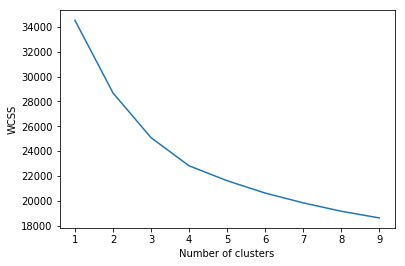

In [16]:
# Plotting the number of clusters vs WCSS
plt.plot(range(1,10),wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Clustering using K-Means

In [17]:
# I chose 4 to see how it goes.
df_scaled = pd.DataFrame(x_scaled)

kmeans = KMeans(4)
kmeans.fit(df_scaled)
identified_clusters = kmeans.fit_predict(df_scaled)

df_scaled_with_clusters = df_scaled.copy()
df_scaled_with_clusters['predicted_cluster']=identified_clusters
df_scaled_with_clusters.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,predicted_cluster
0,"tf.Tensor(1.9762383355443462, shape=(), dtype=...","tf.Tensor(5.586452311329045, shape=(), dtype=f...","tf.Tensor(2.659894990303871, shape=(), dtype=f...","tf.Tensor(3.342115871998229, shape=(), dtype=f...","tf.Tensor(5.036384772356149, shape=(), dtype=f...","tf.Tensor(4.264544733869565, shape=(), dtype=f...","tf.Tensor(0.9942485575792626, shape=(), dtype=...","tf.Tensor(0.13989133208950236, shape=(), dtype...","tf.Tensor(0.5804330521934415, shape=(), dtype=...","tf.Tensor(1.8817633035243129, shape=(), dtype=...",...,"tf.Tensor(2.407951430056441, shape=(), dtype=f...","tf.Tensor(2.9557312194936403, shape=(), dtype=...","tf.Tensor(2.660330903839095, shape=(), dtype=f...","tf.Tensor(2.3262283151576826, shape=(), dtype=...","tf.Tensor(1.066544306099492, shape=(), dtype=f...","tf.Tensor(1.3009300039179175, shape=(), dtype=...","tf.Tensor(1.0965049613338593, shape=(), dtype=...","tf.Tensor(0.12645661725721516, shape=(), dtype...","tf.Tensor(-0.6395071408970116, shape=(), dtype...",2
1,"tf.Tensor(-0.629848609721763, shape=(), dtype=...","tf.Tensor(-0.46376420099828713, shape=(), dtyp...","tf.Tensor(-0.4924454567865067, shape=(), dtype...","tf.Tensor(-0.39447457473493974, shape=(), dtyp...","tf.Tensor(1.639015990832034, shape=(), dtype=f...","tf.Tensor(-0.4702224009515922, shape=(), dtype...","tf.Tensor(-0.3635189722923634, shape=(), dtype...","tf.Tensor(1.0741829543487411, shape=(), dtype=...","tf.Tensor(0.8361018701587075, shape=(), dtype=...","tf.Tensor(0.46425477198701254, shape=(), dtype...",...,"tf.Tensor(0.9569934114347359, shape=(), dtype=...","tf.Tensor(1.2426160152889805, shape=(), dtype=...","tf.Tensor(1.2449261383001207, shape=(), dtype=...","tf.Tensor(1.0585716758092971, shape=(), dtype=...","tf.Tensor(0.801673515632738, shape=(), dtype=f...","tf.Tensor(1.026007700857403, shape=(), dtype=f...","tf.Tensor(0.28182493273076425, shape=(), dtype...","tf.Tensor(0.38191071392112436, shape=(), dtype...","tf.Tensor(0.8845261115799181, shape=(), dtype=...",3
2,"tf.Tensor(0.2800615386752181, shape=(), dtype=...","tf.Tensor(-0.38458523145738294, shape=(), dtyp...","tf.Tensor(-0.388964421231882, shape=(), dtype=...","tf.Tensor(-0.3989878100901442, shape=(), dtype...","tf.Tensor(-0.3561038930577126, shape=(), dtype...","tf.Tensor(-0.43362078014695843, shape=(), dtyp...","tf.Tensor(0.0013985954744711784, shape=(), dty...","tf.Tensor(0.32620960358050655, shape=(), dtype...","tf.Tensor(3.234281610902339, shape=(), dtype=f...","tf.Tensor(0.4464280301617202, shape=(), dtype=...",...,"tf.Tensor(-0.6894632107006468, shape=(), dtype...","tf.Tensor(0.5244282819878403, shape=(), dtype=...","tf.Tensor(1.1958565620744375, shape=(), dtype=...","tf.Tensor(0.8648506841123929, shape=(), dtype=...","tf.Tensor(0.10556532047615398, shape=(), dtype...","tf.Tensor(0.9287179793305201, shape=(), dtype=...","tf.Tensor(-0.39801559016231686, shape=(), dtyp...","tf.Tensor(-0.7967878081857155, shape=(), dtype...","tf.Tensor(-0.7137262691270513, shape=(), dtype...",0
3,"tf.Tensor(-0.3321522739447326, shape=(), dtype...","tf.Tensor(-0.5726352841170302, shape=(), dtype...","tf.Tensor(0.7171454163332964, shape=(), dtype=...","tf.Tensor(-0.3941982542029886, shape=(), dtype...","tf.Tensor(-0.4670232280484809, shape=(), dtype...","tf.Tensor(-0.5558423949350887, shape=(), dtype...","tf.Tensor(-1.0027448799082566, shape=(), dtype...","tf.Tensor(0.03480602679203806, shape=(), dtype...","tf.Tensor(1.9511328869468503, shape=(), dtype=...","tf.Tensor(0.08850609847063629, shape=(), dtype...",...,"tf.Tensor(-0.8588684887608005, shape=(), dtype...","tf.Tensor(-0.6000757686923324, shape=(), dtype...","tf.Tensor(-0.5430606783656563, shape=(), dtype...","tf.Tensor(1.4838439253154412, shape=(), dtype=...","tf.Tensor(1.373171975181281, shape=(), dtype=f...","tf.Tensor(1.4901159240878832, shape=(), dtype=...","tf.Tensor(1.662643824729964, shape=(), dtype=f...","tf.Tensor(1.9092747686273577, shape=(), dtype=...",

### Dimensionality reduction to be able to have a 2D plot 

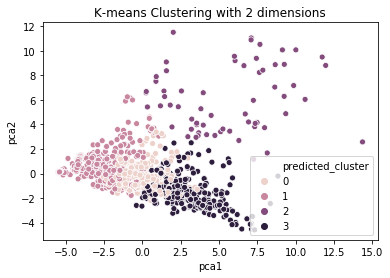

In [18]:
from sklearn.decomposition import PCA

reduced_data = PCA(n_components = 2).fit_transform(df_scaled_with_clusters)
results = pd.DataFrame(reduced_data,columns = ['pca1','pca2'])

sns.scatterplot(x = "pca1", y = "pca2", hue = df_scaled_with_clusters['predicted_cluster'], 
                data = results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()